In [1]:
import matplotlib.pyplot as plt
import numpy as np
from model import get_model, pH, rev_pH, Keq_func, quadratic, get_quasi_model
from model.simulations import iterable_steady_scan_params, iterable_resp_coef_scan_params, simulate_to_steady_state_with_results, find_intersections, take_closest

from tqdm import tqdm
from modelbase2 import Model, Simulator, plot, mca
from concurrent import futures
import pandas as pd

## Get Model and test basic functions

In [2]:
m = get_model()

m.get_stoichiometries()

m.get_variable_names()
m.get_derived_variable_names()

['N0', 'A3', 'PQ_red', 'ADP_st', 'Keq']

In [3]:
m.get_fluxes()

v1    1.666667e+01
v2    4.250000e+06
v3    0.000000e+00
v4    0.000000e+00
v5    2.560000e+03
v6    5.001685e-11
v7    0.000000e+00
v8    0.000000e+00
v9    0.000000e+00
dtype: float64

### Basic Plotting of basic simulation to test if any errors persist

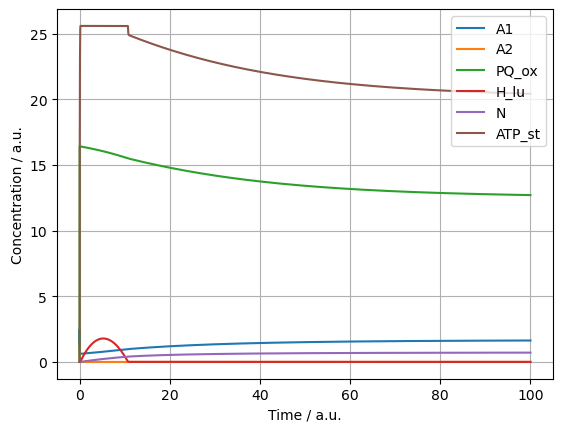

In [4]:
s = Simulator(m)
s.update_parameter("PFD", 1000)
s.simulate(100)
concs = s.get_concs()

if concs is not None:
    fig, ax = plot.lines(concs)
    
    ax.set(xlabel="Time / a.u.", ylabel="Concentration / a.u.")
    
    plt.show

## Figure 4

Steady-State Scan:  30%|███       | 30/100 [00:01<00:02, 24.96it/s][ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8028][cvHandleFailure] At t = 0.166906 and h = 7.37206e-05, the error test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8032][cvHandleFailure] At t = 5.36526 and h = 0.358841, the corrector convergence test failed repeatedly or with |h| = hmin.
Steady-State Scan:  33%|███▎      | 33/100 [00:01<00:03, 19.04it/s]RuntimeWarning: invalid value encountered in log10
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8032][cvHandleFailure] At t = 7.48422 and h = 0.48418, the corrector convergence test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569

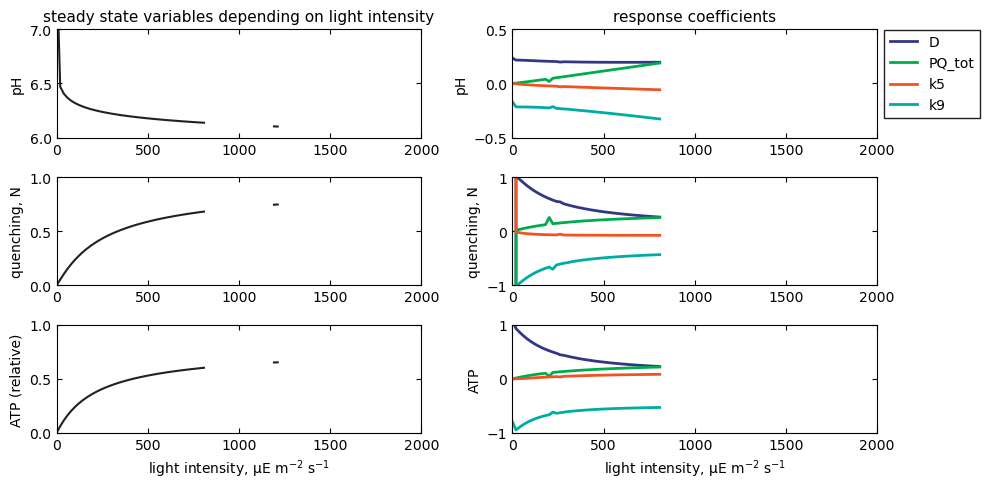

In [3]:
#Get steady state solutions for variable PFD values
scan = iterable_steady_scan_params(
    get_model(),
    param_str = 'PFD',
    param_vals = np.linspace(1e-4, 2000, 100)
)

# Get response coefficients (D, PQ_tot, k5, k9) for variable PFD values
mca_scan = iterable_resp_coef_scan_params(
    m = get_model(),
    param_str = 'PFD',
    param_vals = np.linspace(1e-4, 2000, 100),
    params_to_extract = ["D", "PQ_tot", "k5", "k9"]
)

fig, axs = plt.subplots(3, 2, figsize = (10, 5))

# Plot Lumen pH against PFD
axs[0, 0].plot(scan.index, pH(scan["H_lu"]), color = '#232021')
# Plot Quencher (N) against PFD
axs[1, 0].plot(scan.index, scan["N"], color = '#232021')
# Plot Relative ATP against PFD
axs[2, 0].plot(scan.index, scan["ATP_st"] / get_model().parameters['AP_tot'], color = '#232021')

# Plot all three response coefficient plots
color_dict = {
    'D': '#323784',
    'PQ_tot': '#00ab4e',
    'k5': '#f15221',
    'k9': '#00aba2'
}

for param, color in color_dict.items():
    axs[0, 1].plot(mca_scan.concs.index, [i.loc['H_lu'][param] for i in mca_scan.concs], color = color, label = param, lw = 2)
    axs[1, 1].plot(mca_scan.index, [i.loc['N'][param] for i in mca_scan.concs], color = color, label = param, lw = 2)
    axs[2, 1].plot(mca_scan.index, [i.loc['ATP_st'][param] for i in mca_scan.concs], color = color, label = param, lw = 2)

# Stylings
axs[0, 0].set_yticks([6, 6.5, 7])
axs[0, 0].set_ylim(6, 7)
axs[0, 0].set_ylabel('pH')
axs[0, 0].set_title('steady state variables depending on light intensity', size = '11')

axs[1, 0].set_yticks([0, 0.5, 1])
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_ylabel('quenching, N')

axs[2, 0].set_yticks([0, 0.5, 1])
axs[2, 0].set_ylim(0, 1)
axs[2, 0].set_ylabel('ATP (relative)')
axs[2, 0].set_xlabel(r"light intensity, $\mathrm{\mu E\ m}^{-2}\ \mathrm{s}^{-1}$")

axs[0, 1].set_ylim(-0.5, 0.5)
axs[0, 1].set_yticks([-0.5, 0, 0.5])
axs[0, 1].set_ylabel('pH')
axs[0, 1].set_title('response coefficients', size = '11')

axs[1, 1].set_ylim(-1, 1)
axs[1, 1].set_ylabel('quenching, N')

axs[2, 1].set_ylim(-1, 1)
axs[2, 1].set_ylabel('ATP')
axs[2, 1].set_xlabel(r"light intensity, $\mathrm{\mu E\ m}^{-2}\ \mathrm{s}^{-1}$")

# All xticks
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks([0, 500, 1000, 1500, 2000])
        ax.set_xlim(0, 2000)
        ax.tick_params(
            axis = 'both',
            direction = 'in',
            top = True,
            right = True
        )

# Legend
axs[0, 1].legend(
    loc = 'upper left',
    bbox_to_anchor = (1, 1.06),
    fancybox = False,
    framealpha = 1,
    edgecolor = '#242122'
)

plt.tight_layout()
plt.show()

In [2]:
scan = iterable_steady_scan_params(get_model(), 'PFD', np.linspace(1e-4, 2000, 100))

scan

Steady-State Scan:  32%|███▏      | 32/100 [00:01<00:02, 25.90it/s]RuntimeWarning: invalid value encountered in log10
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8032][cvHandleFailure] At t = 3.77288 and h = 0.239915, the corrector convergence test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8032][cvHandleFailure] At t = 5.41644 and h = 0.33971, the corrector convergence test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8032][cvHandleFailure] At t = 6.84763 and h = 0.53362, the corrector convergence test failed repeatedly or with |h| = hmin.
Steady-State Scan:  36%|███▌      | 36/100 [00:01<00:03, 16.74it/s][ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_17

AttributeError: 'NoneType' object has no attribute 'iloc'

In [46]:
m = get_model()

for i in np.linspace(1e-4, 2000, 100):
    
    m.update_parameter('PFD', i)

    s = Simulator(m)

    rel_norm = False
    tolerance = 1e-8
    try:
        for t_end in np.geomspace(10, 1e9, 5):
            s.simulate(t_end)
            y = s.get_concs()
            diff = (y.iloc[-1] - y.iloc[-2]) / y.iloc[-1] if rel_norm else y.iloc[-1] - y.iloc[-2]
            if np.linalg.norm(diff, ord=2) < tolerance:
                t_, y_ = t_end, y.iloc[-2]
                break
    except:
        t_, y_ = None, None
        

[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8032][cvHandleFailure] At t = 3.77288 and h = 0.239915, the corrector convergence test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8032][cvHandleFailure] At t = 5.41644 and h = 0.33971, the corrector convergence test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8032][cvHandleFailure] At t = 6.84763 and h = 0.53362, the corrector convergence test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8032][cvHandleFailure] At t = 8.27391 and h = 0.298504, the corrector convergence test failed repeatedly or with |h| = hmin.
[ERROR][rank 0

In [38]:
y_

A1         1.659940
A2         0.000184
PQ_ox     12.538838
H_lu       0.003041
N          0.716733
ATP_st    20.151384
Name: 1000.0, dtype: float64

## Figure 5

Steady-State Scan:  30%|███       | 30/100 [00:01<00:02, 24.39it/s][ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8028][cvHandleFailure] At t = 0.166906 and h = 7.37206e-05, the error test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8032][cvHandleFailure] At t = 5.36526 and h = 0.358841, the corrector convergence test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:8028][cvHandleFailure] At t = 0.115948 and h = 6.4419e-05, the error test failed repeatedly or with |h| = hmin.
Steady-State Scan:  33%|███▎      | 33/100 [00:01<00:03, 17.23it/s]RuntimeWarning: invalid value encountered in log10
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundia

TypeError: 'NoneType' object is not subscriptable

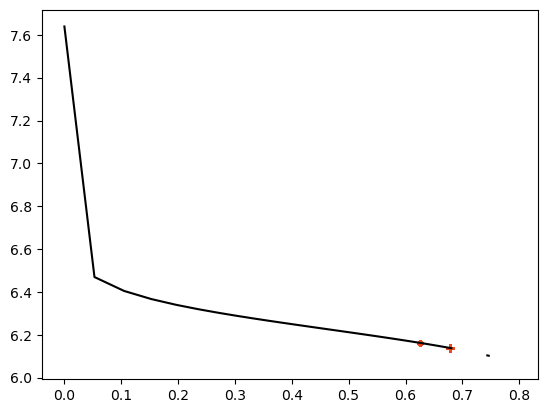

In [2]:
#Get steady state solutions for variable PFD values
scan = iterable_steady_scan_params(
    get_model(),
    param_str = 'PFD',
    param_vals = np.linspace(1e-4, 2000, 100)
)

fig, ax = plt.subplots()

# Plot steady state solutions for variable PFD values (black line)
ax.plot(scan["N"], pH(scan["H_lu"]), c="k", zorder = 5)

# Style Dictionary for easier styling
style_dict = {
    '600': {
        'Marker': '.'
    },
    '800': {
        'Marker': '+'
    },
    '1000': {
        'Marker': 'x'
    },
    '1200': {
        'Marker': 's'
    },
}

t = tqdm(style_dict.items(), total = len(style_dict.keys()))
for pfd, style in t:
    t.set_description(f"Calculating for PFD {pfd}")
    # Run Simulations for dark to light
    s = Simulator(get_model())
    
    s.update_parameter("PFD", int(pfd))
    
    simulate_to_steady_state_with_results(s = s)

    res_dtl = s.get_full_concs()
    plt.plot(res_dtl["N"], pH(res_dtl["H_lu"]), c="#ef481e")
    
    # Create List of times and results that are near to 1s Intervalls
    time = res_dtl.index
    marker_times = [take_closest(time, i) for i in range(0, int(time[-1] + 1))]
    marker_res = res_dtl.loc[marker_times]
    plt.plot(marker_res["N"], pH(marker_res["H_lu"]), label = pfd, c = "#ef481e", marker = style['Marker'], lw = 0)
    
    # Interpolate results to find intersections with steady-state scan
    xx, interp_res = find_intersections (
        scan["N"],
        pH(scan['H_lu']),
        res_dtl["N"],
        pH(res_dtl["H_lu"])
    )
    
    ax.plot(xx, interp_res,
             marker = 'o', fillstyle = "none", markeredgewidth = 3, markersize = 15,
             c = '#ef481e',
             zorder = 3, )
    
    # Simulate from light to dark
    y0_new = s.get_new_y0()
    s.clear_results()
    s.y0 = y0_new
    s.update_parameter("PFD", get_model().get_args()['PFD'])
    
    simulate_to_steady_state_with_results(s = s)
    res_ltd = s.get_full_concs()
    plt.plot(res_ltd["N"], pH(res_ltd["H_lu"]), c="#28338d")
    
# Finishing Style
ax.legend()
ax.set_xlabel("quenching activity, N")
ax.set_ylabel("lumen pH")
ax.set_xlim(0, 0.8)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_ylim(3, 7)
ax.set_yticks([3, 4, 5, 6, 7])

plt.tight_layout()
plt.show()

s.simulate_to_steady_state()

  0%|          | 0/3 [00:00<?, ?it/s]

[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 532.333 and h = 3.86926e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 532.333 and h = 3.86926e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 565.667 and h = 3.90654e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 565.667 and h = 3.90654e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 599 and h = 3.9537e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 599 and h = 3.9537e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 632.333 and h = 4.00812e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 632.333 and h = 4.00812e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 665.667 and h = 4.06794e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 665.667 and h = 4.06794e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 699 and h = 4.13179e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 699 and h = 4.13179e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 732.333 and h = 4.19864e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 732.333 and h = 4.19864e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 765.667 and h = 4.26771e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 765.667 and h = 4.26771e-14 are such that t + h = t on the next step. The solver will continue anyway.


 33%|███▎      | 1/3 [00:14<00:29, 14.92s/it]

[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 532.333 and h = 4.12582e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 532.333 and h = 4.12582e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 565.667 and h = 4.10873e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 565.667 and h = 4.10873e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 599 and h = 4.11558e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 599 and h = 4.11558e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 632.333 and h = 4.13925e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 632.333 and h = 4.13925e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 665.667 and h = 4.1751e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 665.667 and h = 4.1751e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 699 and h = 4.21995e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 699 and h = 4.21995e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 732.333 and h = 4.27155e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 732.333 and h = 4.27155e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 765.667 and h = 4.32825e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 765.667 and h = 4.32825e-14 are such that t + h = t on the next step. The solver will continue anyway.


 67%|██████▋   | 2/3 [00:29<00:14, 14.50s/it]

[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 532.333 and h = 4.39472e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 532.333 and h = 4.39472e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 565.667 and h = 4.31165e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 565.667 and h = 4.31165e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 599 and h = 4.27298e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 599 and h = 4.27298e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 632.333 and h = 4.26375e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 632.333 and h = 4.26375e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 665.667 and h = 4.275e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 665.667 and h = 4.275e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 699 and h = 4.30097e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 699 and h = 4.30097e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 732.333 and h = 4.33781e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 732.333 and h = 4.33781e-14 are such that t + h = t on the next step. The solver will continue anyway.


[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 765.667 and h = 4.38277e-14 are such that t + h = t on the next step. The solver will continue anyway.
[WARNING][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1719462973569/work/sundials/src/cvodes/cvodes.c:3482][CVode] Internal t = 765.667 and h = 4.38277e-14 are such that t + h = t on the next step. The solver will continue anyway.


100%|██████████| 3/3 [00:42<00:00, 14.25s/it]


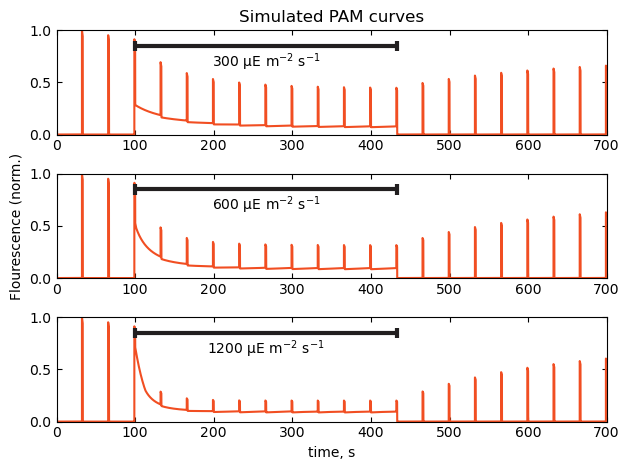

In [ ]:
def simulate_PAM(
    m: Model,
    actinic_light: float = 0,
    actinic_light_start: float = 100,
    actinic_light_end: float = 400 + 100/3,
    start_PAM: float = 0,
    end_PAM: float = 800,
    sp_step: float = 100 / 3,
    sp_pfd: float = 4000
):
    s = Simulator(m)
    s.update_parameter("PFD", 0)
    s.initialise(y0)
    
    for step in tqdm(np.arange(start_PAM, end_PAM, sp_step)):
        if step == 0:
            continue
        
        s.simulate(step - 1, atol=1e-12, rtol=1e-12)
        
        s.update_parameter("PFD", sp_pfd)
        s.simulate(step, atol=1e-12, rtol=1e-12)
        if step >= actinic_light_start and step < actinic_light_end:
            norm_pfd = actinic_light
        else:
            norm_pfd = 0
        s.update_parameter("PFD", norm_pfd)

    res = s.get_full_results_df()
    res = res.drop(0)
    res = res[res.index >= 1]
    flou = (1 - res["N"]) * res["A3"] / get_model().parameters["D"]
    rel_flou = flou - min(flou)
    rel_flou = flou / max(flou)
    
    return rel_flou

def create_figure7():
    fig, axs = plt.subplots(nrows = 3)
    
    actinic_lights = [300, 600, 1200]
    
    for i in tqdm(range(len(actinic_lights))):
        res = simulate_PAM(get_model(), actinic_lights[i])
        axs[i].plot(res,
                    color = "#f14e22"
                    )
        axs[i].set_ylim(0, 1)
        axs[i].set_yticks([0, 0.5, 1])
        axs[i].set_xlim(0, 700)
        axs[i].set_xticks(np.arange(0, 700 + 100, 100))
        axs[i].tick_params(
                axis = 'both',
                direction = 'in',
                top = True,
                right = True
            )
        # Actinic Light section styling
        x1 = 100
        x2 = 400 + 100 / 3
        height = 0.1
        y = 0.85
        
        axs[i].hlines(y, x1, x2, lw = 3, color = '#221f20')
        axs[i].vlines([x1, x2], y - height / 2, y + height / 2, lw = 3, color = '#221f20')
        axs[i].text(x = (x2 - x1) / 2 + x1, y = y - height / 2, s = fr'{actinic_lights[i]} $\mathrm{{\mu E\ m}}^{{-2}}\ \mathrm{{s}}^{{-1}}$', ha = 'center', va = 'top')
        
    axs[0].set_title("Simulated PAM curves")
    axs[1].set_ylabel("Flourescence (norm.)")
    axs[2].set_xlabel("time, s")
    
    return fig

fig = create_figure7()
plt.tight_layout()
plt.show()

### Figure 3

In [ ]:
def constant_light(
    m: Model,
    pH_lumen: float,
    KQ: float = None,
    Keq: float = None,
):
    # Parameters
    params = m.get_all_parameters()
    
    k7 = params["k7"]
    k6 = params["k6"]
    n = params["n"]
    k5 = params["k5"]
    k9 = params["k9"]
    AP_tot = params["AP_tot"]
    k3p = params["k3p"]
    k4 = params["k4"]
    k1 = params["k1"]
    k2 = params["k2"]
    k3m = params["k3m"]
    D = params["D"]
    PQ_tot = params["PQ_tot"]

    if KQ is None:
        KQ = params["KQ"]
        
    H = rev_pH(pH_lumen)
    
    if Keq is None:
        Keq = Keq_func(
            H_lu = H,
            DG0 = params["DG0"],
            H_st = params["H_st"],
            RT = params["RT"],
            Pi = params["Pi"]
        )
        
    N = 1 / (1 + (k7 / k6) * (H**n + (KQ ** n) / (H ** n)))
    ATP_st = AP_tot / (1 + (1 / Keq) + (k5/k9))
    v5 = k5 * (AP_tot - ATP_st * (1 + 1 / Keq))
    
    f = 1 - N
    alpha = k3p * k4 * (1 / (f * k1) + 1 / k2)
    beta = k3m * k4 / (f * k1)

    PQ_ox = quadratic(
        a = alpha - beta,
        b = k3p * D - alpha * PQ_tot + 2 * beta * PQ_tot + k4,
        c = -beta * PQ_tot**2 - k4 * PQ_tot,
        option='max'
    )
    
    v2 = k4 * (PQ_tot - PQ_ox)
    
    
    return N, ATP_st, v5, v2

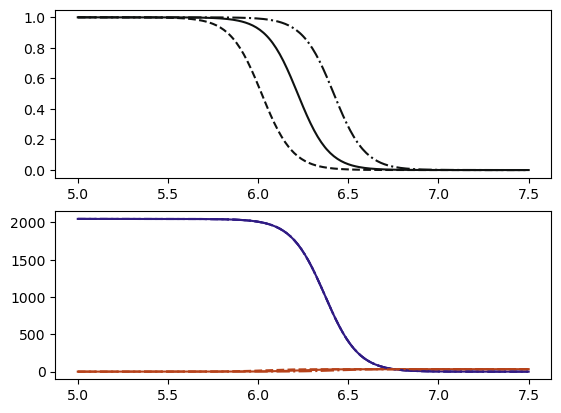

In [ ]:
fig, axs = plt.subplots(nrows = 2)

style_dict = {
    "6": {
        'ls': 'solid'
    },
    '5.8': {
        'ls': 'dashed'
    },
    '6.2': {
        'ls': 'dashdot'
    }
}

step = 0.01
pH_lumen = np.arange(5, 7.5 + step, step)

for KQ_pH, style in style_dict.items():
    N, ATP_st, v5, v2 = constant_light(
        m = get_model(),
        pH_lumen = pH_lumen,
        KQ = rev_pH(float(KQ_pH))
    )
    axs[0].plot(pH_lumen, N, color = "#0f1211", ls = style['ls'], label = KQ_pH)
    axs[1].plot(pH_lumen, v5, color = "#301b84", ls = style['ls'])
    axs[1].plot(pH_lumen, v2, color = "#b6421a", ls = style['ls'])


plt.show()

In [ ]:
m = get_model()

m.update_parameter("PFD", 800)

N = []

for pH_lumen in np.arange(5, 8, 0.5):
    print(pH_lumen)
    y0 = {
        "A1": m.parameters["D"] / 2,
        "A2": m.parameters["D"] / 2,
        "PQ_ox": 0,
        "H_lu": rev_pH(pH_lumen),
        "N": 0,
        "ATP_st": 0,
    }
    s = Simulator(m)
    s.initialise(y0)
    
    s.simulate(1000)
    res = s.get_fluxes_df()
    N.append(res['v4'].iloc[0] + res['v2'].iloc[0])
    
    
    
print(N)

5.0
5.5
6.0
6.5
7.0
7.5
[np.float64(4250000.0), np.float64(4250000.0), np.float64(4250000.0), np.float64(4250000.0), np.float64(4250000.0), np.float64(4250000.0)]
